In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings;warnings.simplefilter('ignore')
from scripts import datasources, models, variables

In [3]:
county_dict = {
    'Alameda': '001', 'Contra Costa': '013', 'Marin': '041', 'Napa': '055', 'San Francisco': '075',
    'San Mateo': '081', 'Santa Clara': '085', 'Solano': '095', 'Sonoma': '097'
}

In [4]:
persons_w_jobs = pd.read_csv('./data/persons_w_jobs_2018_10_26.csv', index_col='person_id')

### Aggregate WLCM-assigned commute flows

In [5]:
orca.run(['initialize_network_small', 'initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [6]:
orca.add_table('persons', persons_w_jobs)

In [7]:
orca.broadcast('jobs', 'persons', cast_index=True, onto_on='job_id')

In [8]:
df_hh_geog = orca.merge_tables('persons', ['persons', 'households', 'units', 'buildings', 'parcels'])[['block_id']]

In [9]:
df_w_geog = orca.merge_tables('persons', ['persons', 'jobs', 'buildings', 'parcels'])[['block_id']]

In [43]:
ods = pd.merge(df_hh_geog, df_w_geog, left_index=True, right_index=True, suffixes=('_h', '_w'))

In [44]:
ods['tract_id_h'] = ods['block_id_h'].str[0:11]
ods['county_id_h'] = ods['block_id_h'].str[0:5]
ods['tract_id_w'] = ods['block_id_w'].str[0:11]
ods['county_id_w'] = ods['block_id_w'].str[0:5]

In [45]:
ods = ods[['county_id_h', 'county_id_w', 'tract_id_h', 'tract_id_w', 'block_id_h', 'block_id_w']]

In [19]:
od_county_counts = ods[['county_id_h', 'county_id_w']].reset_index().groupby(['county_id_h', 'county_id_w']).count().reset_index().rename(columns={'person_id': 'count'})
od_tract_counts = ods[['tract_id_h', 'tract_id_w']].reset_index().groupby(['tract_id_h', 'tract_id_w']).count().reset_index().rename(columns={'person_id': 'count'})

### Aggregate LODES data

In [21]:
lodes = pd.read_csv(
    './data/ca_od_main_JT01_2011.csv.gz',
    dtype={'w_geocode': str, 'h_geocode': str}, usecols=['w_geocode', 'h_geocode', 'S000'],
    compression='gzip')

In [22]:
lodes['tract_id_h'] = lodes['h_geocode'].str[0:11]
lodes['county_id_h'] = lodes['h_geocode'].str[0:5]
lodes['tract_id_w'] = lodes['w_geocode'].str[0:11]
lodes['county_id_w'] = lodes['w_geocode'].str[0:5]

In [23]:
lodes_county_od_counts = lodes[['county_id_h', 'county_id_w', 'S000']].groupby(['county_id_h', 'county_id_w']).sum().reset_index().rename(columns={'S000': 'count'})
lodes_tract_od_counts = lodes[['tract_id_h', 'tract_id_w', 'S000']].groupby(['tract_id_h', 'tract_id_w']).sum().reset_index().rename(columns={'S000': 'count'})

### Merge WLCM results with LODES

In [25]:
merged_county = pd.merge(od_county_counts, lodes_county_od_counts, on=['county_id_h', 'county_id_w'], suffixes=('_synth', '_lodes'))
merged_tract = pd.merge(od_tract_counts, lodes_tract_od_counts, on=['tract_id_h', 'tract_id_w'], suffixes=('_synth', '_lodes'))

In [26]:
merged_county['pct_synth'] = merged_county['count_synth'] / merged_county['count_synth'].sum()
merged_county['pct_lodes'] = merged_county['count_lodes'] / merged_county['count_lodes'].sum()
merged_county['normed_pct_diff'] = merged_county['pct_lodes'] - merged_county['pct_synth']
merged_tract['pct_synth'] = merged_tract['count_synth'] / merged_tract['count_synth'].sum()
merged_tract['pct_lodes'] = merged_tract['count_lodes'] / merged_tract['count_lodes'].sum()
merged_tract['normed_pct_diff'] = merged_tract['pct_lodes'] - merged_tract['pct_synth']

### High-level comparison of WLCM to LODES

In [114]:
synth_jobs_geog = orca.merge_tables('jobs',['jobs', 'buildings', 'parcels'])[['block_id']]

In [115]:
synth_jobs_geog

,block_id
job_id,
0,060816138003032
1,060816138003032
23,060816134003042
47,060816132004001
48,060816132004001
49,060816132004001
50,060816132004001
51,060816132004001
52,060816132004001


In [27]:
merged_county['count_lodes'].sum()

2547832

In [28]:
merged_county['count_synth'].sum()

2578046

In [29]:
(merged_county['count_lodes'].sum() - merged_county['count_synth'].sum())/merged_county['count_lodes'].sum()

-0.011858709679445113

### County-level flows

In [30]:
merged_county['pct_diff'] = (merged_county['count_lodes'] - merged_county['count_synth']) / merged_county['count_lodes'] * 100

Text(0.5,1,'County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics')

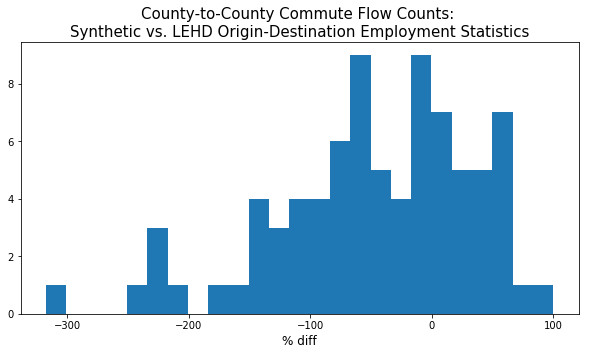

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(merged_county['pct_diff'], bins=25)
ax.set_xlabel('% diff', fontsize=12)
ax.set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

Text(0.5,1,'County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics')

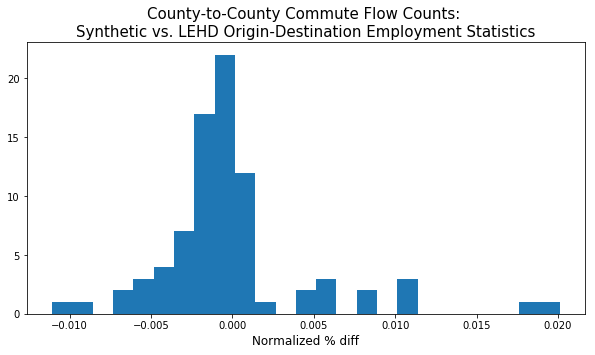

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(merged_county['normed_pct_diff'], bins=25)
ax.set_xlabel('Normalized % diff', fontsize=12)
ax.set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

In [54]:
merged_county[merged_county['county_id_w'] == '06075']

,county_id_h,county_id_w,count_synth,count_lodes,pct_synth,pct_lodes,normed_pct_diff,pct_diff
4,06001,06075,69525,70494,0.026968,0.027668,0.000700,1.374585
13,06013,06075,47039,46484,0.018246,0.018245,-0.000001,-1.193959
22,06041,06075,24033,23456,0.009322,0.009206,-0.000116,-2.459925
31,06055,06075,4187,2187,0.001624,0.000858,-0.000766,-91.449474
40,06075,06075,167669,216910,0.065037,0.085135,0.020098,22.701120
49,06081,06075,59525,68885,0.023089,0.027037,0.003948,13.587864
58,06085,06075,9549,23323,0.003704,0.009154,0.005450,59.057583
68,06095,06075,13270,9983,0.005147,0.003918,-0.001229,-32.925974
77,06097,06075,15533,8743,0.006025,0.003432,-0.002594,-77.662130


Text(0.5,0,'LODES')

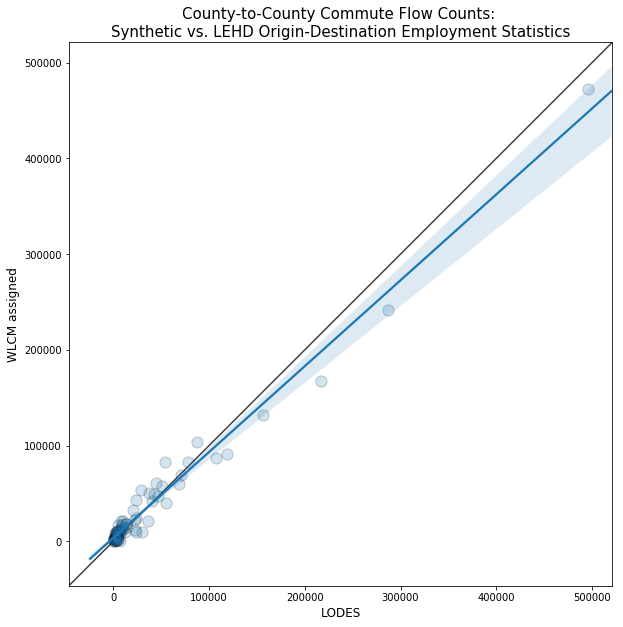

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'count_lodes', 'count_synth', merged_county,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

# label specific points
ax.text(point['x']+.02, point['y'], str(point['val']))

Text(6706,133539,'Contra Costa')

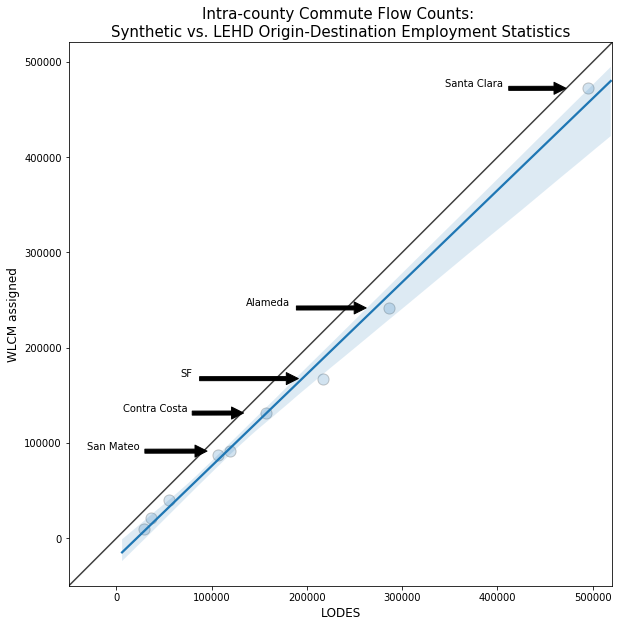

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
plot_df = merged_county[merged_county['county_id_h'] == merged_county['county_id_w']]
sns.regplot(
    'count_lodes', 'count_synth', plot_df,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Intra-county Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

## label specific points
# Alameda to SF commute
row = plot_df[(plot_df['county_id_h'] == '06001') & (plot_df['county_id_w'] == '06001')]
ax.annotate(
    'Alameda',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06075') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'SF',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06081') & (plot_df['county_id_w'] == '06081')]
ax.annotate(
    'San Mateo',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'Santa Clara',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)


row = plot_df[(plot_df['county_id_h'] == '06013') & (plot_df['county_id_w'] == '06013')]
ax.annotate(
    'Contra Costa',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)


Text(3620,72780,'Santa Clara --> Alameda')

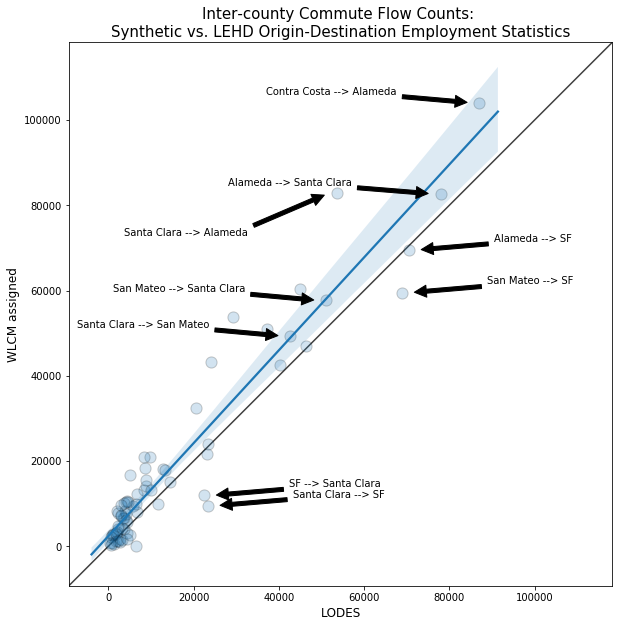

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
plot_df = merged_county[merged_county['county_id_h'] != merged_county['county_id_w']]
sns.regplot(
    'count_lodes', 'count_synth', plot_df,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Inter-county Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

## label specific points
# Alameda to SF commute
row = plot_df[(plot_df['county_id_h'] == '06001') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'Alameda --> SF',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06075') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'SF --> Santa Clara',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06081') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'San Mateo --> SF',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'Santa Clara --> SF',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06081') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'San Mateo --> Santa Clara',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06081')]
ax.annotate(
    'Santa Clara --> San Mateo',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06013') & (plot_df['county_id_w'] == '06001')]
ax.annotate(
    'Contra Costa --> Alameda',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06001') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'Alameda --> Santa Clara',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)


row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06001')]
ax.annotate(
    'Santa Clara --> Alameda',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] - 10000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

Text(0.5,0,'LODES')

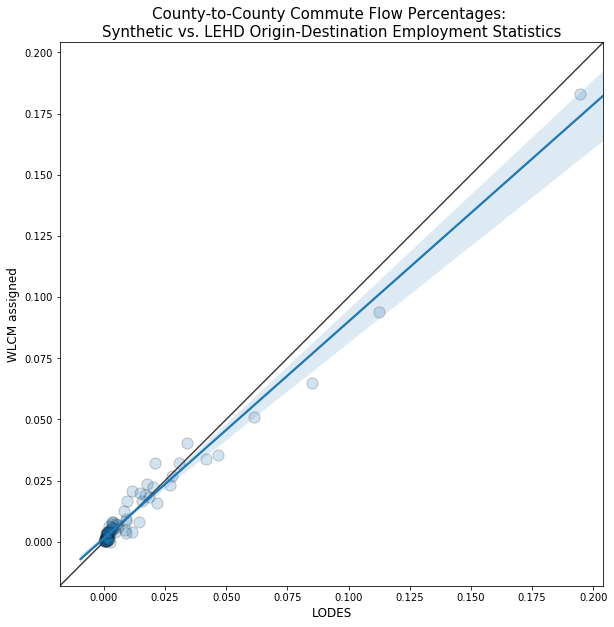

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'pct_lodes', 'pct_synth', merged_county,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('County-to-County Commute Flow Percentages: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

### Commute Distance Distributions

In [35]:
blocks = gpd.read_file('./data/Blocks/bayarea_blocks.shp')

In [36]:
blocks = blocks.to_crs(crs={'init': 'epsg:2768'})

In [37]:
blocks['centroid'] = blocks['geometry'].centroid

In [38]:
lodes = lodes[['h_geocode','w_geocode']].merge(blocks, left_on='w_geocode', right_on='blockid10')

In [39]:
lodes = lodes.merge(blocks, left_on='h_geocode', right_on='blockid10', suffixes=('_w', '_h'))

In [40]:
lodes['distance_m'] = gpd.GeoSeries(lodes['centroid_h']).distance(gpd.GeoSeries(lodes['centroid_w']))

In [46]:
ods = ods[['block_id_h','block_id_w']].merge(blocks, left_on='block_id_w', right_on='blockid10')

In [47]:
ods = ods.merge(blocks, left_on='block_id_h', right_on='blockid10', suffixes=('_w', '_h'))

In [48]:
ods['distance_m'] = gpd.GeoSeries(ods['centroid_h']).distance(gpd.GeoSeries(ods['centroid_w']))

Text(0.5,0,'Census Block to Census Block Commute Distances (m)')

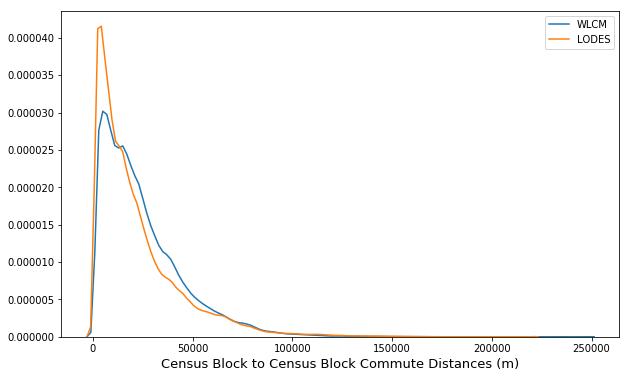

In [49]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(ods['distance_m'],ax=ax, label='WLCM')
sns.kdeplot(lodes['distance_m'], ax=ax, label='LODES')
ax.set_xlabel('Census Block to Census Block Commute Distances (m)', fontsize=13)

### Workplace counts by census block